In [ ]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from diffusers import StableDiffusionImg2ImgPipeline, DDPMScheduler, UNet2DConditionModel, AutoencoderKL, DDIMScheduler
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from transformers import CLIPTokenizer, CLIPTextModel
from accelerate import Accelerator
from safetensors.torch import load_file
from PIL import Image
import torch
import numpy as np 
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import gc

fuck up


In [2]:
import torch
torch.cuda.empty_cache()

# Dataset

### Load data

DatasetDict({
    train: Dataset({
        features: ['original_image', 'edit_prompt', 'cartoonized_image'],
        num_rows: 5000
    })
})
{'train': (5000, 3)}
Give the natural image a hand-drawn, animated look.


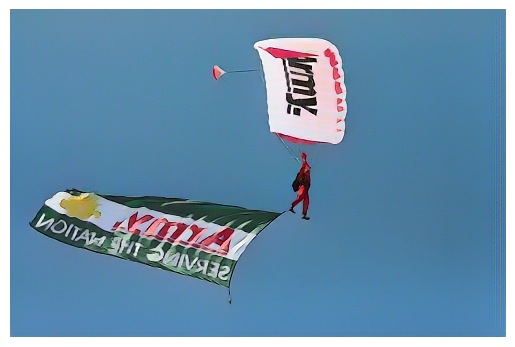

In [3]:
dataset = load_dataset("instruction-tuning-sd/cartoonization")

# Display the first image in the dataset
print(dataset)
print(dataset.shape)
print(dataset['train'][8]['edit_prompt'])
image = dataset['train'][8]['cartoonized_image']
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

### Preprocess the dataset

In [4]:
# image transformation
image_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def preprocess_image(batch):
    images = [image_transforms(img) for img in batch['cartoonized_image']]
    texts = batch['edit_prompt']
    return {"images": images, "texts": texts}

In [5]:
# Create a DataLoader
train_loader = DataLoader(dataset['train'].with_transform(preprocess_image), batch_size=8, shuffle=True)

# Training

### Load pretrained components of stable diffusion

In [12]:
model_id = "runwayml/stable-diffusion-v1-5"

pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16
).to("cuda")

print(pipeline.config)

# 1. Load Tokenizer & Text Encoder (keep on CPU)
tokenizer = pipeline.tokenizer
text_encoder = pipeline.text_encoder.to("cuda")

# 2. Load VAE for encoding/decoding (keep on CPU, use FP16)
vae = pipeline.vae.to("cuda")

# 3. Load UNet with FP16 (but keep on CPU for now)
unet = pipeline.unet.to("cuda")

# 4. Load Scheduler
scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


FrozenDict([('vae', ('diffusers', 'AutoencoderKL')), ('text_encoder', ('transformers', 'CLIPTextModel')), ('tokenizer', ('transformers', 'CLIPTokenizer')), ('unet', ('diffusers', 'UNet2DConditionModel')), ('scheduler', ('diffusers', 'PNDMScheduler')), ('safety_checker', ('stable_diffusion', 'StableDiffusionSafetyChecker')), ('feature_extractor', ('transformers', 'CLIPImageProcessor')), ('image_encoder', (None, None)), ('requires_safety_checker', True), ('_name_or_path', 'runwayml/stable-diffusion-v1-5')])


### Apply Lora

In [17]:
# Define LoRA configuration
lora_config = LoraConfig(
    r=16,  # Rank of LoRA update matrices
    lora_alpha=32,  # Scaling factor
    target_modules=["to_q", "to_k", "to_v"],  # Target attention layers in U-Net
    lora_dropout=0.1,
    bias="none"
)

# Inject LoRA into the U-Net
unet = get_peft_model(unet, lora_config)
unet.print_trainable_parameters()  # Check trainable parameter count

trainable params: 2,390,016 || all params: 861,910,980 || trainable%: 0.2773


### Loss function definition

In [8]:
# Load noise scheduler (to simulate forward diffusion process)
model_id = "runwayml/stable-diffusion-v1-5"

def compute_loss_with_cfg(model, latents, prompts, text_encoder, tokenizer, guidance_scale=7.5):
    """
    Computes classifier-free guidance loss for fine-tuning Stable Diffusion's U-Net.

    Args:
        model: The U-Net model from Stable Diffusion.
        batch: Batch of images and text prompts.
        text_encoder: CLIP text encoder (for embedding text prompts).
        tokenizer: CLIP tokenizer.
        guidance_scale: Strength of classifier-free guidance.

    Returns:
        loss (torch.Tensor): The computed MSE loss.
    """

    device = unet.device
    dtype = model.dtype

    latents = latents.to(device, dtype)

    # generate noise
    noise = torch.randn_like(latents, dtype=dtype)

    # Sample random timesteps
    timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()

    # Add noise to images
    noisy_images = scheduler.add_noise(latents, noise, timesteps)

    # Tokenize text prompts (conditional)
    text_inputs = tokenizer(prompts, padding="max_length", max_length=77, return_tensors="pt").to(device)
    text_embeddings = text_encoder(**text_inputs).last_hidden_state.to(dtype)  # Shape: (B, 77, 768)

    # Unconditional embeddings (empty prompt)
    uncond_inputs = tokenizer([""] * len(prompts), padding="max_length", max_length=77, return_tensors="pt").to(device)
    uncond_embeddings = text_encoder(**uncond_inputs).last_hidden_state.to(dtype) 

    # concatenate embeddings
    combined_embeddings = torch.cat([text_embeddings, uncond_embeddings], dim=0).to(dtype)

    # duplicate images and timesteps
    noisy_images = torch.cat([noisy_images, noisy_images], dim=0).to(device, dtype)
    timesteps = torch.cat([timesteps, timesteps], dim=0).to(device)

    # Forward pass via U-Net
    noise_pred = model(noisy_images, timesteps, combined_embeddings).sample

    # split predictions
    noise_pred_cond, noise_pred_uncond = torch.chunk(noise_pred, 2, dim=0)

    # compute classifier-free guidance loss
    guidance_loss = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

    # compute MSE loss
    mse_loss = F.mse_loss(guidance_loss, noise)

    return mse_loss

### pixel to latent space

In [9]:
def encode_images(vae, images):
    """
    Encodes a batch of RGB images into latent space using the VAE encoder.
    
    Args:
        vae: Pretrained VAE model from Stable Diffusion.
        images (torch.Tensor): Tensor of shape (B, 3, H, W), values in [0, 1].

    Returns:
        torch.Tensor: Latent representation (B, 4, H//8, W//8).
    """
    images = images.to(dtype=torch.float32, device="cuda")  # Move to GPU & set dtype
    vae.to(dtype=torch.float32, device="cuda")  # Ensure VAE is also in float16
    images = images * 2 - 1  # Scale to [-1, 1]
    
    with torch.no_grad():
        latents = vae.encode(images).latent_dist.sample() * 0.18215  # Encode & scale

    return latents.to("cuda")  # Ensure latents are on GPU

def decode_latents(vae, latents):
    """
    Decodes latents into RGB images using the VAE decoder.

    Args:
        vae: Pretrained VAE model.
        latents (torch.Tensor): Latent tensor of shape (B, 4, H//8, W//8).

    Returns:
        torch.Tensor: Decoded images in [0, 1] range.
    """
    decoded_image = vae.decode(latents / 0.18215).sample
    return decoded_image


### Training loop

In [ ]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-6, weight_decay=1e-2)
# unet = PeftModel.from_pretrained(unet, "./checkpoint/fine-tuned-unet-cartoonization").to("cpu")
# lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.98)

num_epochs = 20
for epoch in range(num_epochs):
    unet.train()
    total_loss = 0
    unet = unet.to("cuda")

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        images = batch["images"].to("cpu")  # Extract images (B, 3, H, W)

        # Encode images to latent space
        latents = encode_images(vae, images)  # Shape: (B, 4, H//8, W//8)

        prompt = batch["texts"]
        
        # Compute loss with classifier-free guidance
        loss = compute_loss_with_cfg(unet, latents, prompt, text_encoder, tokenizer).to(torch.float32)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

    # Save fine-tuned model
    if (epoch + 1) % 5 == 0:
        unet.save_pretrained(f"./checkpoint/fine-tuned-unet-cartoonization{epoch + 1}_r=32")

  0%|          | 0/625 [00:00<?, ?it/s]

100%|██████████| 625/625 [11:56<00:00,  1.15s/it]


Epoch 1, Loss: 0.3312


100%|██████████| 625/625 [11:54<00:00,  1.14s/it]


Epoch 2, Loss: 0.2707


100%|██████████| 625/625 [11:52<00:00,  1.14s/it]


Epoch 3, Loss: 0.2281


100%|██████████| 625/625 [11:52<00:00,  1.14s/it]


Epoch 4, Loss: 0.2018


100%|██████████| 625/625 [11:54<00:00,  1.14s/it]


Epoch 5, Loss: 0.1911


100%|██████████| 625/625 [11:53<00:00,  1.14s/it]


Epoch 6, Loss: 0.1771


100%|██████████| 625/625 [11:51<00:00,  1.14s/it]


Epoch 7, Loss: 0.1761


100%|██████████| 625/625 [11:49<00:00,  1.14s/it]


Epoch 8, Loss: 0.1737


100%|██████████| 625/625 [11:52<00:00,  1.14s/it]


Epoch 9, Loss: 0.1638


100%|██████████| 625/625 [11:52<00:00,  1.14s/it]


Epoch 10, Loss: 0.1618


100%|██████████| 625/625 [11:55<00:00,  1.14s/it]


Epoch 11, Loss: 0.1623


100%|██████████| 625/625 [11:53<00:00,  1.14s/it]


Epoch 12, Loss: 0.1539


100%|██████████| 625/625 [11:53<00:00,  1.14s/it]


Epoch 13, Loss: 0.1562


100%|██████████| 625/625 [11:49<00:00,  1.14s/it]


Epoch 14, Loss: 0.1502


100%|██████████| 625/625 [11:51<00:00,  1.14s/it]


Epoch 15, Loss: 0.1556


100%|██████████| 625/625 [11:50<00:00,  1.14s/it]


Epoch 16, Loss: 0.1540


100%|██████████| 625/625 [11:50<00:00,  1.14s/it]


Epoch 17, Loss: 0.1530


 24%|██▍       | 151/625 [02:50<08:48,  1.12s/it]

# Testing

100%|██████████| 51/51 [00:04<00:00, 12.27it/s]


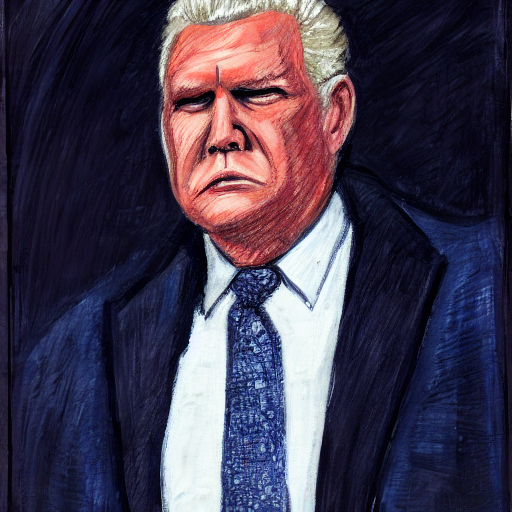

In [36]:
# Load each component separately
model_id = "runwayml/stable-diffusion-v1-5"

# Load the model
pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16
).to("cuda")

# 1. Load Tokenizer & Text Encoder (keep on CPU)
tokenizer = pipeline.tokenizer
text_encoder = pipeline.text_encoder.to("cpu")

# 2. Load VAE for encoding/decoding (keep on CPU, use FP16)
vae = pipeline.vae.to("cpu")

# 3. Load UNet with FP16 (but keep on CPU for now)
unet = pipeline.unet.to("cpu")
unet = PeftModel.from_pretrained(unet, "./checkpoint/fine-tuned-unet-cartoonization15_r=32").to("cpu")

# 4. Load Scheduler
scheduler = pipeline.scheduler

# Load and process reference image
ref_image = Image.open("./images/trump.jpg").convert("RGB").resize((512, 512))
ref_image = np.array(ref_image).astype(np.float16) / 255.0  # Normalize
ref_image = torch.tensor(ref_image).permute(2, 0, 1).unsqueeze(0).to("cuda")

# Encode image into latent space (move VAE to GPU only for encoding)
vae.to("cuda")
with torch.no_grad():
    latents = vae.encode(ref_image * 2 - 1).latent_dist.sample() * 0.18215  # Scale factor
    latents = latents.to("cuda")

# Move VAE back to CPU to free GPU memory
vae.to("cpu")
torch.cuda.empty_cache()  # Free memory

# Tokenize prompt
prompt = "a cartoonized American white man with blonde hair, furious and arrogant, blue eyes, old and wrinkled face, wearing a suit and a tie, simple contour, easy sketch, less details"
text_inputs = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt")
text_embeddings = text_encoder(text_inputs.input_ids.to("cpu"))[0].to("cuda")
# Duplicate text embeddings for CFG
text_embeddings_uncond = text_encoder(tokenizer("", padding="max_length", return_tensors="pt").input_ids.to("cpu"))[0].to("cuda")

# Run denoising steps (move UNet to GPU)
guidance_scale = 7.5
unet.to("cuda")
scheduler.set_timesteps(50)
# Add noise to latent image representation
noise = torch.randn_like(latents).to("cuda")  # Generate Gaussian noise
latents = scheduler.add_noise(latents, noise, torch.tensor([scheduler.timesteps[0]]).to("cuda"))

with torch.no_grad():
    for t in tqdm(scheduler.timesteps):
        noise_pred_uncond = unet(latents, t, encoder_hidden_states=text_embeddings_uncond).sample
        noise_pred_text = unet(latents, t, encoder_hidden_states=text_embeddings).sample
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        latents = scheduler.step(noise_pred, t, latents).prev_sample
# Move UNet back to CPU after use
unet.to("cpu")
torch.cuda.empty_cache()

# Decode latents into an image (move VAE to GPU only for decoding)
vae.to("cuda")
with torch.no_grad():
    decoded_image = vae.decode(latents / 0.18215).sample

# Move VAE back to CPU after decoding
vae.to("cpu")
torch.cuda.empty_cache()

# Convert to PIL image
decoded_image = ((decoded_image / 2 + 0.5).clamp(0, 1) * 255).byte()
decoded_image = decoded_image.permute(0, 2, 3, 1).cpu().numpy()[0]

# Save and display
output_image = Image.fromarray(decoded_image)
output_image.show()
output_image.save("./lora15_r=32.jpg")

# Final cleanup to free memory
del unet, vae, text_encoder, latents, text_embeddings
gc.collect()
torch.cuda.empty_cache()
